In [6]:
#import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cProfile
import pstats
import line_profiler as lp
import pprofile
import timeit
import cupy as cp
import numpy

plt.interactive(True)


nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))



# The pressure Poisson equation that's written above can be hard to write out without typos. The function build_up_b below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.
def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))
    return b



# The function pressure_poisson is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable nit. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.
def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    #p = cp.asarray(p)
    #pn = cp.asarray(pn)
    #b = cp.asarray(b)

    for q in range(nit):
        pn = p.copy()
        #pn = cp.asarray(pn)
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                            (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                            (2 * (dx**2 + dy**2)) -
                            dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                            b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
         
    #p = p.get()
    return p



# Finally, the rest of the cavity flow equations are wrapped inside the function cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.
def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    print('caviry dlow called: nt=',nt)
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    for n in range(nt):
        un = u.copy()
        vn = v.copy() 
        
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        p = pressure_poisson(p, dx, dy, b)
 
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0  

    #p = numpy.ndarray.get(p, stream=None, order='C', out=None)

    return u, v, p








def main():
    # Let's start with nt = 100 and see what the solver gives us:

    u = numpy.zeros((ny, nx))
    v = numpy.zeros((ny, nx))
    p = numpy.zeros((ny, nx))
    b = numpy.zeros((ny, nx))
    nt = 10200
    
    u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
    #x = numpy.ndarray.get(x, stream=None, order='C', out=None)
    #y = numpy.ndarray.get(y, stream=None, order='C', out=None)


    fig = pyplot.figure(figsize=(11,7), dpi=100)
    # plotting the pressure field as a contour
    pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
    pyplot.colorbar()
    # plotting the pressure field outlines
    pyplot.contour(X, Y, p, cmap=cm.viridis)  
    # plotting velocity field
    pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
    pyplot.xlabel('X')
    pyplot.ylabel('Y');







caviry dlow called: nt= 10200
Timer unit: 1e-09 s

Total time: 9.06502 s
File: /tmp/ipykernel_10397/3545466343.py
Function: pressure_poisson at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           def pressure_poisson(p, dx, dy, b):
    54     10200   21403567.0   2098.4      0.2      pn = numpy.empty_like(p)
    55     10200   12027295.0   1179.1      0.1      pn = p.copy()
    56                                               #p = cp.asarray(p)
    57                                               #pn = cp.asarray(pn)
    58                                               #b = cp.asarray(b)
    59                                           
    60    510000   95220642.0    186.7      1.1      for q in range(nit):
    61    510000  535901453.0   1050.8      5.9          pn = p.copy()
    62                                                   #pn = cp.asarray(pn)
    63    510000 2557227345.0   5014.2     28.2          p[1:-1

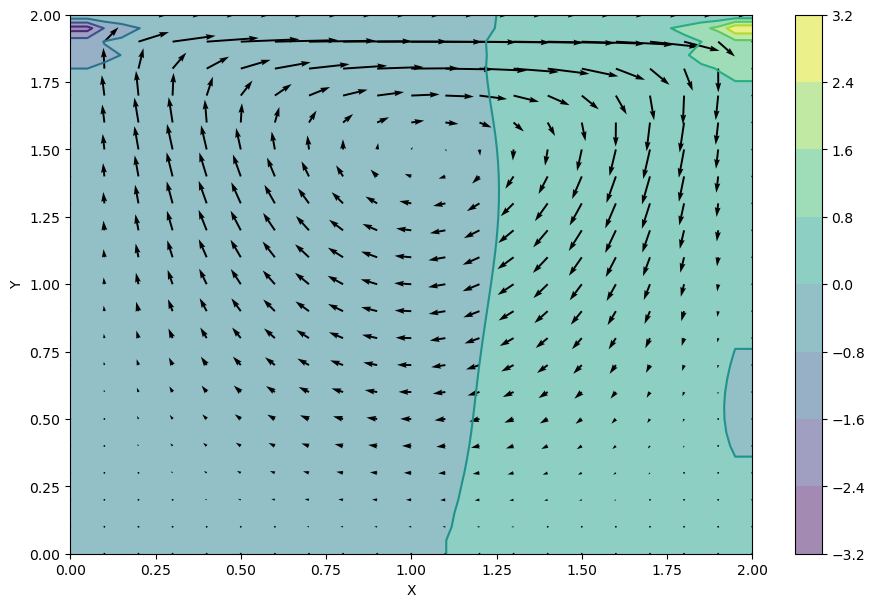

In [7]:
'''Line profiler'''
profiler = lp.LineProfiler()
profiler.add_function(cavity_flow)
profiler.add_function(pressure_poisson)
profiler_wrapper = profiler(main)
profiler_wrapper()
profiler.print_stats()
#main()

In [3]:
import torch
torch.cuda.is_available()


True